In [1]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

# 1) Data

- We will use real-world demographic data taken from LandScan [1].


- The desired information pertaining to the population of the city of Rio de Janeiro has been extracted by the ModSiming team from UFRJ [2].

[1] https://landscan.ornl.gov/

[2] https://github.com/ModSiming/EpiSiming

In [2]:
landscan_rio = np.load('landscan_rio_paqueta.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)
landscan_rio_xscale = 0.85239
landscan_rio_yscale = 0.926
landscan_rio_ydim, landscan_rio_xdim = landscan_rio.shape

print(f'Dimensão da matriz de blocos: {landscan_rio.shape}')
print(f'Total de blocos: {landscan_rio_xdim*landscan_rio_ydim}')
print(f'Total de blocos habitados: {len(landscan_rio[landscan_rio>0])}')

Dimensão da matriz de blocos: (39, 83)
Total de blocos: 3237
Total de blocos habitados: 1473


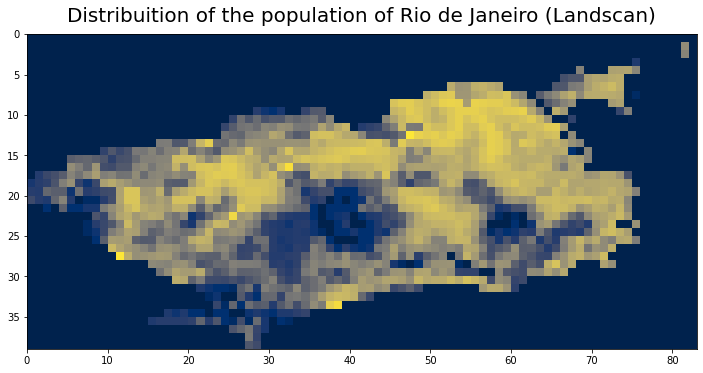

In [3]:
landscan_rio_plot = landscan_rio
landscan_rio_plot[np.where(landscan_rio == np.sort(landscan_rio.ravel())[-1])] = np.sort(landscan_rio.ravel())[-2]
landscan_rio_plot = np.log(1 + landscan_rio_plot) + 0.000_1*landscan_rio_plot

plt.figure(figsize = (12,6))
ext = [0, landscan_rio_xdim, landscan_rio_ydim, 0]
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.title("Distribuition of the population of Rio de Janeiro (Landscan)", fontsize = 20, y = 1.02);

# 2) Linear signal decay (concave objective function)

In [4]:
var = cp.Variable(2)

res_x_1 = (var[0] >= 0); res_x_2 = (var[0] <= landscan_rio_xdim-1)
res_y_1 = (var[1] >= 0); res_y_2 = (var[1] <= landscan_rio_ydim-1)
res = [res_x_1, res_x_2, res_y_2, res_y_2]

pts_x = np.arange(landscan_rio_xdim)
pts_y = np.arange(landscan_rio_ydim)
pts_x_meshgrid, pts_y_meshgrid = np.meshgrid(pts_x, pts_y)
all_pts = np.column_stack((pts_x_meshgrid.ravel(), pts_y_meshgrid.ravel()))

landscan_rio_flat = landscan_rio.ravel()

all_pts = all_pts[landscan_rio_flat > 0]
landscan_rio_flat = landscan_rio_flat[landscan_rio_flat > 0]

xy_scale = np.diag([landscan_rio_xscale, landscan_rio_yscale])

def d_to_all_pts(v): return cp.norm((all_pts - np.ones_like(all_pts) @ cp.diag(v)) @ xy_scale, axis = 1)
def s(d): return -d

f_obj =  s(d_to_all_pts(var)) @ landscan_rio_flat

pb = cp.Problem(cp.Maximize(f_obj), res)
pb.solve()

-91553320.68669418

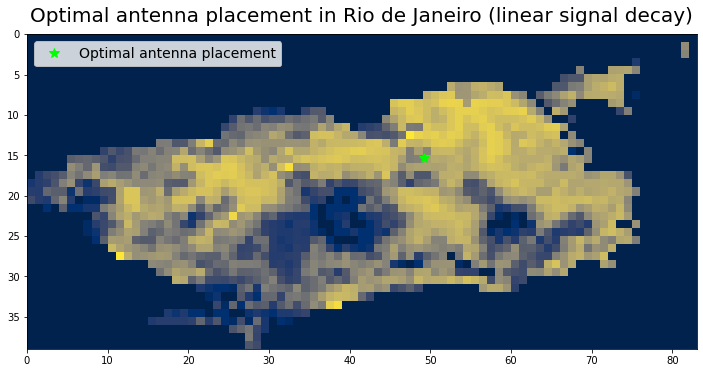

In [5]:
loc_opt_lin = np.array(var.value)

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_lin[0], loc_opt_lin[1], '*', color = 'lime', markersize = 10, label = "Optimal antenna placement")
plt.title("Optimal antenna placement in Rio de Janeiro (linear signal decay)", fontsize = 20, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

# 3) Exponential signal decay (non-convex/concave objetive funtion)

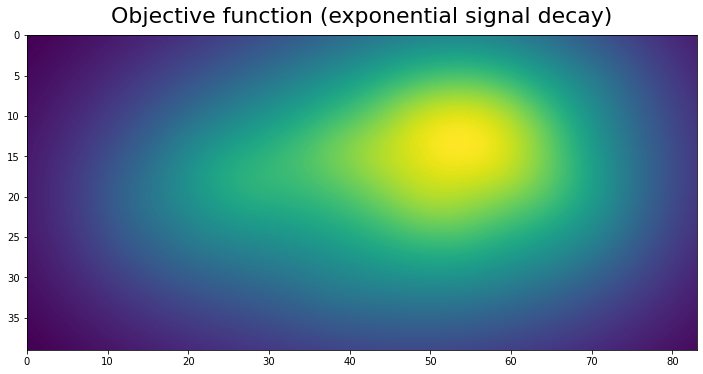

In [6]:
def d_to_all_pts(v): return np.linalg.norm((all_pts - v) @ xy_scale, axis = 1)
#c = 0.25
c = 0.1
def s(d): return np.exp(-c*d)

def f_obj(v): return s(d_to_all_pts(v)) @ landscan_rio_flat
grad_f = grad(f_obj)

M = 200
N = 200
X = np.linspace(0, landscan_rio_xdim, M)
Y = np.linspace(0, landscan_rio_ydim, N)

F = np.reshape([f_obj(np.array([x,y])) for y in Y for x in X], (M,N))

plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.title("Objective function (exponential signal decay)", fontsize = 22, y = 1.02);

## 3.1) Concave approximations

In [ ]:
loc_curr = np.array([55.5,25.5])

plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.plot(loc_curr[0], loc_curr[1], 'o', color = 'red', label = "loc_curr")
plt.title("Objective function (exponential signal decay)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

In [ ]:
f_obj_loc_curr = f_obj(loc_curr)
grad_f_loc_curr = grad_f(loc_curr)
R = 2_000.

def f_ccv_approx(v): return f_obj_loc_curr + grad_f_loc_curr@(v - loc_curr) - R*np.inner(v - loc_curr, v - loc_curr)
A = np.reshape([f_ccv_approx(np.array([x,y])) for y in Y for x in X], (N,M))

plt.figure(figsize=(12,6))
plt.imshow(A, extent = ext)
plt.plot(loc_curr[0], loc_curr[1], 'o', color = 'r', label = "loc_curr")
plt.title("Objective function (concave approximation)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

In [ ]:
var = cp.Variable(2)

res_x_1 = (var[0] >= 0); res_x_2 = (var[0] <= landscan_rio_xdim-1)
res_y_1 = (var[1] >= 0); res_y_2 = (var[1] <= landscan_rio_ydim-1)
res = [res_x_1, res_x_2, res_y_1, res_y_2]

f_ccv_approx = f_obj_loc_curr + grad_f_loc_curr@(var - loc_curr) - R*cp.sum_squares(var - loc_curr)

pb = cp.Problem(cp.Maximize(f_ccv_approx), res)
pb.solve()

In [ ]:
loc_next = np.array(var.value)

plt.figure(figsize=(12,6))
plt.imshow(A, extent = ext)
plt.plot(loc_curr[0], loc_curr[1], 'o', color = 'r', label = "loc_curr")
plt.plot(loc_next[0], loc_next[1], 'o', color = 'm', label = "loc_next")
plt.title("Objective function (concave approximation)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(F, extent = ext)
plt.plot(loc_curr[0], loc_curr[1], 'o', color = 'r', label = "loc_curr")
plt.plot(loc_next[0], loc_next[1], 'o', color = 'm', label = "loc_next")
plt.title("Optimal antenna placement (approximations)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

In [ ]:
f_obj(loc_curr)

In [ ]:
f_obj(loc_next)

In [ ]:
grad_f_loc_curr = cp.Parameter(2)
R = cp.Parameter(nonneg = True)

f_ccv_approx = grad_f_loc_curr@(var - loc_curr) - R*cp.sum_squares(var - loc_curr)
pb = cp.Problem(cp.Maximize(f_ccv_approx), res)
pb

In [ ]:
loc_curr = np.array([55.5, 15.5])
f_obj_loc_curr = f_obj(loc_curr)
grad_f_loc_curr.value = grad_f(loc_curr)
#grad_f_loc_curr.value = grad_f_loc_curr.value / np.linalg.norm(grad_f_loc_curr.value)
R.value = 2_000.
locs = loc_curr

print("R =", R.value)

for i in range(10):
    pb.solve(solver = 'ECOS')
    loc_next = np.array(var.value)
    f_obj_loc_next = f_obj(loc_next)
    
    print("f_obj_loc_curr =", f_obj_loc_curr)        
    print("f_obj_loc_next =", f_obj_loc_next)
    
    while f_obj_loc_next < f_obj_loc_curr:
        R.value = 2 * R.value
        print("R =", R.value)
        pb.solve(solver = 'ECOS')
        loc_next = np.array(var.value)
        f_obj_loc_next = f_obj(loc_next)
        print("f_obj_loc_curr =", f_obj_loc_curr)        
        print("f_obj_loc_next =", f_obj_loc_next)        
    
    print("\nloc_next ACCEPTED.\n")
    loc_curr = loc_next
    f_obj_loc_curr = f_obj_loc_next
    grad_f_loc_curr.value = grad_f(loc_curr)
    #grad_f_loc_curr.value = grad_f_loc_curr.value / np.linalg.norm(grad_f_loc_curr.value)
    R.value = R.value / 2
    print("R =", R.value)
    
    locs = np.vstack([locs, loc_curr])

In [ ]:
locs

## 3.2) Gradient "ascent"

In [7]:
loc_curr = np.array([30.001, 30.001])
f_obj_loc_curr = f_obj(loc_curr)
grad_f_loc_curr = grad_f(loc_curr)
λ = 1.
locs = loc_curr

for i in range(100):
    loc_next = loc_curr + λ*grad_f_loc_curr
    f_obj_loc_next = f_obj(loc_next)
    
    while f_obj_loc_next < f_obj_loc_curr:
        λ = λ/2
        loc_next = loc_curr + λ*grad_f_loc_curr
        f_obj_loc_next = f_obj(loc_next)       

    if np.linalg.norm(loc_curr - loc_next) < 1e-3:
        break
        
    loc_curr = loc_next
    f_obj_loc_curr = f_obj_loc_next
    grad_f_loc_curr = grad_f(loc_curr)
    λ = λ*2
    
    locs = np.vstack([locs, loc_curr])

In [8]:
len(locs)

10

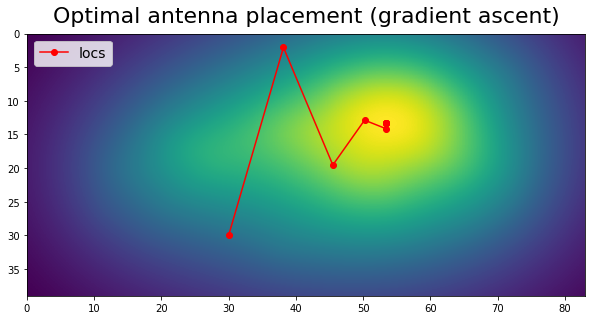

In [9]:
#lim_l = 40
#lim_r = 60
#lim_d = 5
#lim_u = 25
lim_l = 0
lim_r = landscan_rio_xdim
lim_d = landscan_rio_ydim
lim_u = 0

M = 200
N = 200
X = np.linspace(lim_l, lim_r, M)
Y = np.linspace(lim_d, lim_u, N)

F_zoom = np.reshape([f_obj(np.array([x,y])) for y in Y for x in X], (M,N))

plt.figure(figsize=(10,10))
plt.imshow(F_zoom, extent = [lim_l, lim_r, lim_u, lim_d])
plt.plot(locs[:,0], locs[:,1], marker = 'o', color = 'r', label = "locs")
plt.title("Optimal antenna placement (gradient ascent)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);
plt.xlim(lim_l,lim_r)
plt.ylim(lim_d,lim_u);

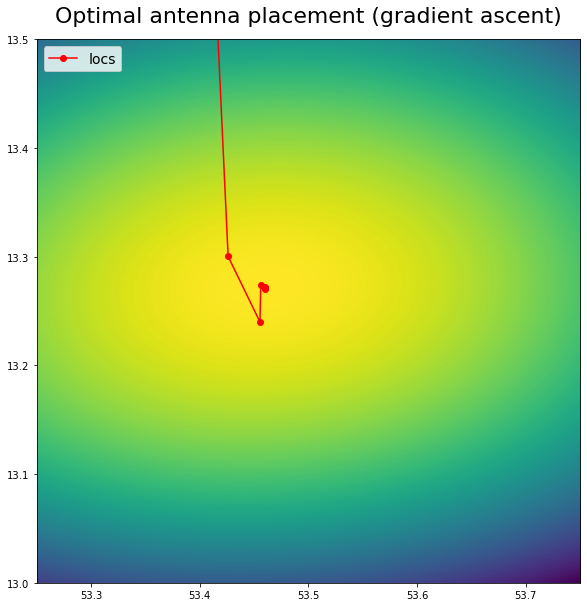

In [10]:
lim_l = 53.25
lim_r = 53.75
lim_d = 13
lim_u = 13.5

M = 200
N = 200
X = np.linspace(lim_l, lim_r, M)
Y = np.linspace(lim_d, lim_u, N)

F_zoom = np.reshape([f_obj(np.array([x,y])) for y in Y for x in X], (M,N))

plt.figure(figsize=(10,10))
plt.imshow(F_zoom, extent = [lim_l, lim_r, lim_u, lim_d])
plt.plot(locs[:,0], locs[:,1], marker = 'o', color = 'r', label = "locs")
plt.title("Optimal antenna placement (gradient ascent)", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);
plt.xlim(lim_l,lim_r)
plt.ylim(lim_d,lim_u);

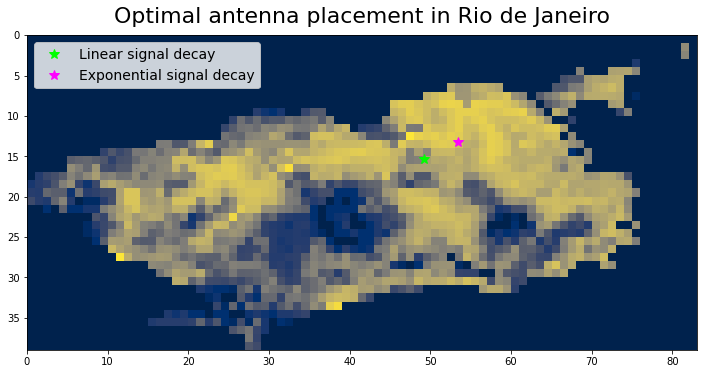

In [11]:
loc_opt_exp = locs[-1]

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_lin[0], loc_opt_lin[1], '*', color = 'lime', markersize = 10, label = "Linear signal decay")
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'fuchsia', markersize = 10, label = "Exponential signal decay")
plt.title("Optimal antenna placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14);

# 4) Problem with N antennae 
## 4.1) Problem with 2 antennae

In [12]:
def d_to_all_pts(v): return np.linalg.norm((all_pts - v) @ xy_scale, axis = 1)
#c = 0.25
c = 0.1
def s(d): return np.exp(-c*d)

def f_obj(v): return s(np.min(np.vstack([d_to_all_pts(v[0:2]), d_to_all_pts(v[2:4])]), axis = 0)) @ landscan_rio_flat
grad_f = grad(f_obj)

In [13]:
#loc_curr_1 = loc_opt_exp
loc_init_1 = np.array([75.001, 5.001])
loc_init_2 = np.array([30.001, 30.001])
loc_curr = np.hstack([loc_init_1, loc_init_2])

f_obj_loc_curr = f_obj(loc_curr)
grad_f_loc_curr = grad_f(loc_curr)
λ = 1.
locs = loc_curr

for i in range(1_000):
    #print(f_obj_loc_curr)
    loc_next = loc_curr + λ*grad_f_loc_curr
    f_obj_loc_next = f_obj(loc_next)
    
    while f_obj_loc_next < f_obj_loc_curr:
        λ = λ/2
        loc_next = loc_curr + λ*grad_f_loc_curr
        f_obj_loc_next = f_obj(loc_next)       

    if np.linalg.norm(loc_curr - loc_next) < 1e-5:
        break
        
    loc_curr = loc_next
    f_obj_loc_curr = f_obj_loc_next
    grad_f_loc_curr = grad_f(loc_curr)
    λ = λ*2
    
    locs = np.vstack([locs, loc_curr])

In [14]:
len(locs)

28

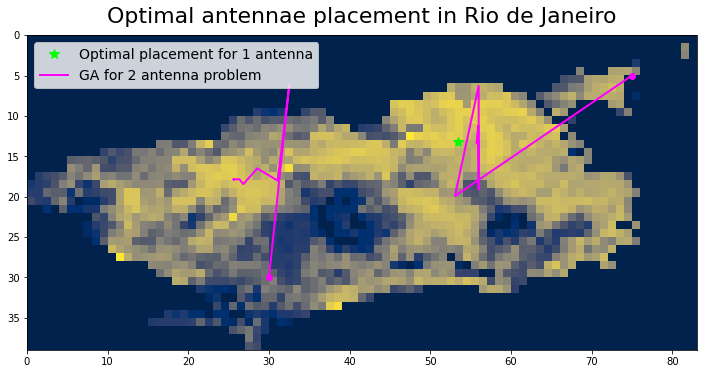

In [15]:
loc_opt_1_x = locs[:,0]
loc_opt_1_y = locs[:,1]
loc_opt_2_x = locs[:,2]
loc_opt_2_y = locs[:,3]

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")
plt.plot(loc_opt_1_x, loc_opt_1_y, color = 'fuchsia', lw = 2, label = "GA for 2 antenna problem")
plt.plot(loc_opt_2_x, loc_opt_2_y, color = 'fuchsia', lw = 2)
plt.plot(loc_opt_1_x[0], loc_opt_1_y[0], 'o', color = 'fuchsia')
plt.plot(loc_opt_2_x[0], loc_opt_2_y[0], 'o', color = 'fuchsia')
plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

### 4.1.1) Visualizing multiple starting points

loc_opt = [55.87291653 13.19761743 25.64572593 17.85721056]


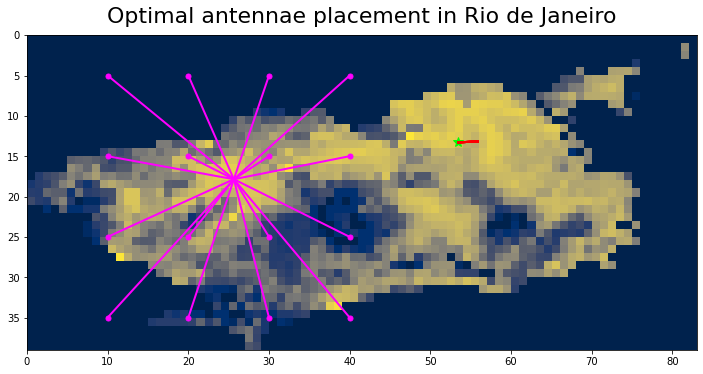

In [16]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")

init_xs = [10,20,30,40]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_f_obj = []
final_locs = []

for init_x, init_y in zip(init_xs_meshgrid, init_ys_meshgrid):
    loc_init_1 = loc_opt_exp
    loc_init_2 = np.array([init_x, init_y])
    loc_curr = np.hstack([loc_init_1, loc_init_2])
    locs = loc_curr

    f_obj_loc_curr = f_obj(loc_curr)
    grad_f_loc_curr = grad_f(loc_curr)
    λ = 1

    for i in range(1_000):
        #print(f_obj_loc_curr)
        loc_next = loc_curr + λ*grad_f_loc_curr
        f_obj_loc_next = f_obj(loc_next)

        while f_obj_loc_next < f_obj_loc_curr:
            λ = λ/2
            loc_next = loc_curr + λ*grad_f_loc_curr
            f_obj_loc_next = f_obj(loc_next)       

        if np.linalg.norm(loc_curr - loc_next) < 1e-5:
            break

        loc_curr = loc_next
        f_obj_loc_curr = f_obj_loc_next
        grad_f_loc_curr = grad_f(loc_curr)
        λ = λ*2

        locs = np.vstack([locs, loc_curr])
    
    final_f_obj += [f_obj_loc_curr]
    final_locs += [loc_curr]
    
    plt.plot([locs[0,0], locs[-1,0]], [locs[0,1], locs[-1,1]], lw =2, color = 'red')
    plt.plot([locs[0,2], locs[-1,2]], [locs[0,3], locs[-1,3]], lw =2, color = 'fuchsia')
    plt.plot(locs[0,2], locs[0,3], 'o', markersize = 5, lw = 2, color = 'fuchsia')
    
loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
#plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

loc_opt = [55.87291653 13.19761743 25.64572593 17.85721056]


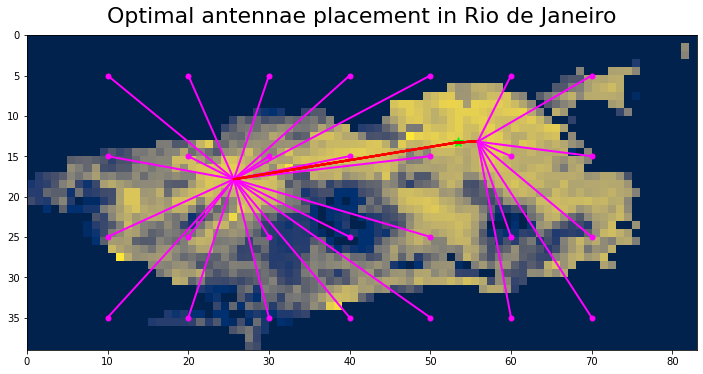

In [17]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")

init_xs = [10,20,30,40,50,60,70]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_f_obj = []
final_locs = []

for init_x, init_y in zip(init_xs_meshgrid, init_ys_meshgrid):
    loc_init_1 = loc_opt_exp
    loc_init_2 = np.array([init_x, init_y])
    loc_curr = np.hstack([loc_init_1, loc_init_2])
    locs = loc_curr

    f_obj_loc_curr = f_obj(loc_curr)
    grad_f_loc_curr = grad_f(loc_curr)
    λ = 1

    for i in range(1_000):
        loc_next = loc_curr + λ*grad_f_loc_curr
        f_obj_loc_next = f_obj(loc_next)

        while f_obj_loc_next < f_obj_loc_curr:
            λ = λ/2
            loc_next = loc_curr + λ*grad_f_loc_curr
            f_obj_loc_next = f_obj(loc_next)       

        if np.linalg.norm(loc_curr - loc_next) < 1e-5:
            break

        loc_curr = loc_next
        f_obj_loc_curr = f_obj_loc_next
        grad_f_loc_curr = grad_f(loc_curr)
        λ = λ*2

        locs = np.vstack([locs, loc_curr])
    
    final_f_obj += [f_obj_loc_curr]
    final_locs += [loc_curr]
    
    plt.plot([locs[0,0], locs[-1,0]], [locs[0,1], locs[-1,1]], lw =2, color = 'red')
    plt.plot([locs[0,2], locs[-1,2]], [locs[0,3], locs[-1,3]], lw =2, color = 'fuchsia')
    plt.plot(locs[0,2], locs[0,3], 'o', markersize = 5, lw = 2, color = 'fuchsia')
        
loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
#plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

loc_opt = [55.87291909 13.19761766 25.64572824 17.85721096]


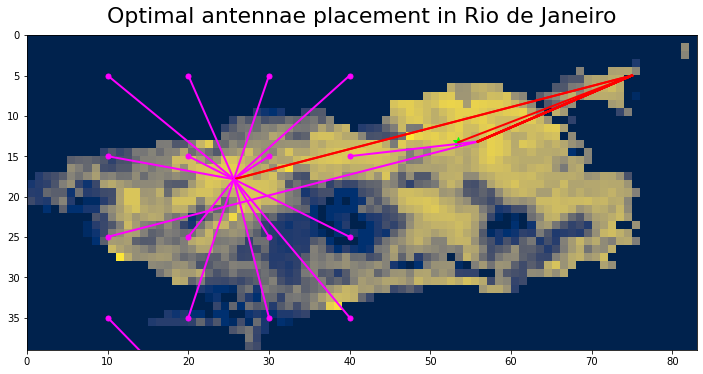

In [18]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")

init_xs = [10,20,30,40]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_f_obj = []
final_locs = []

for init_x, init_y in zip(init_xs_meshgrid, init_ys_meshgrid):
    loc_init_1 = np.array([75.001, 5.001])
    loc_init_2 = np.array([init_x, init_y])
    loc_curr = np.hstack([loc_init_1, loc_init_2])
    locs = loc_curr

    f_obj_loc_curr = f_obj(loc_curr)
    grad_f_loc_curr = grad_f(loc_curr)
    λ = 1

    for i in range(1_000):
        loc_next = loc_curr + λ*grad_f_loc_curr
        f_obj_loc_next = f_obj(loc_next)

        while f_obj_loc_next < f_obj_loc_curr:
            λ = λ/2
            loc_next = loc_curr + λ*grad_f_loc_curr
            f_obj_loc_next = f_obj(loc_next)       

        if np.linalg.norm(loc_curr - loc_next) < 1e-5:
            break

        loc_curr = loc_next
        f_obj_loc_curr = f_obj_loc_next
        grad_f_loc_curr = grad_f(loc_curr)
        λ = λ*2

        locs = np.vstack([locs, loc_curr])
    
    final_f_obj += [f_obj_loc_curr]
    final_locs += [loc_curr]
    
    plt.plot([locs[0,0], locs[-1,0]], [locs[0,1], locs[-1,1]], lw =2, color = 'red')
    plt.plot([locs[0,2], locs[-1,2]], [locs[0,3], locs[-1,3]], lw =2, color = 'fuchsia')
    plt.plot(locs[0,2], locs[0,3], 'o', markersize = 5, lw = 2, color = 'fuchsia')

loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)
        
plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
#plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0)
plt.show();

loc_opt = [55.872919   13.19761729 25.64572804 17.8572132 ]


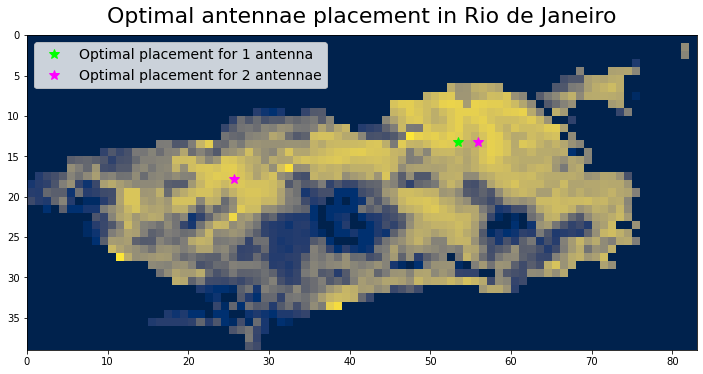

In [19]:
init_xs = [10,25,40,55,70]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_f_obj = []
final_locs = []

for loc_init_1 in zip(init_xs_meshgrid, init_ys_meshgrid):
    for loc_init_2 in zip(init_xs_meshgrid, init_ys_meshgrid):
        loc_curr = np.hstack([loc_init_1, loc_init_2])
        locs = loc_curr

        f_obj_loc_curr = f_obj(loc_curr)
        grad_f_loc_curr = grad_f(loc_curr)
        λ = 1

        for i in range(1_000):
            loc_next = loc_curr + λ*grad_f_loc_curr
            f_obj_loc_next = f_obj(loc_next)

            while f_obj_loc_next < f_obj_loc_curr:
                λ = λ/2
                loc_next = loc_curr + λ*grad_f_loc_curr
                f_obj_loc_next = f_obj(loc_next)       

            if np.linalg.norm(loc_curr - loc_next) < 1e-5:
                break

            loc_curr = loc_next
            f_obj_loc_curr = f_obj_loc_next
            grad_f_loc_curr = grad_f(loc_curr)
            λ = λ*2

            locs = np.vstack([locs, loc_curr])

        final_f_obj += [f_obj_loc_curr]
        final_locs += [loc_curr]

loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")
plt.plot(loc_opt[0], loc_opt[1], '*', color = 'fuchsia', markersize = 10, label = "Optimal placement for 2 antennae")
plt.plot(loc_opt[2], loc_opt[3], '*', color = 'fuchsia', markersize = 10)
plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

### 4.1.2) Implementing a logarithmic barrier

In [20]:
def f_obj(v):
    log_barrier = np.sum(np.log(np.hstack([v, np.array([landscan_rio_xdim, landscan_rio_ydim]*2) - v])))
    return s(np.min(np.vstack([d_to_all_pts(v[0:2]), d_to_all_pts(v[2:4])]), axis = 0)) @ landscan_rio_flat + log_barrier
grad_f = grad(f_obj)

loc_opt = [55.87291744 13.19761995 25.6457321  17.85721179]


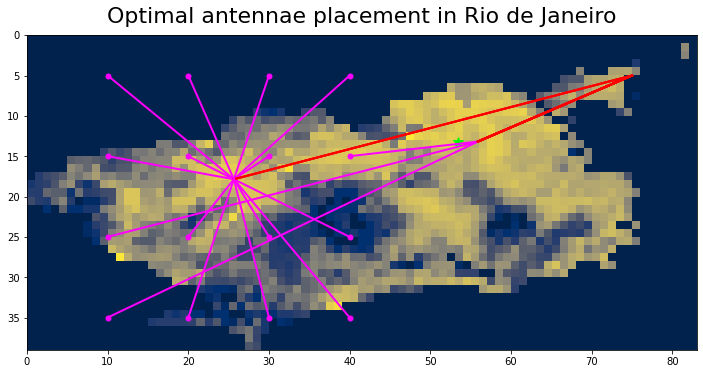

In [21]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")

init_xs = [10,20,30,40]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_f_obj = []
final_locs = []

for init_x, init_y in zip(init_xs_meshgrid, init_ys_meshgrid):
    loc_init_1 = np.array([75.001, 5.001])
    loc_init_2 = np.array([init_x, init_y])
    loc_curr = np.hstack([loc_init_1, loc_init_2])
    locs = loc_curr

    f_obj_loc_curr = f_obj(loc_curr)
    grad_f_loc_curr = grad_f(loc_curr)
    λ = 1

    for i in range(1_000):
        loc_next = loc_curr + λ*grad_f_loc_curr
        if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim]*2) - loc_next]) <= 0):
            f_obj_loc_next = -np.inf
        else:
            f_obj_loc_next = f_obj(loc_next)

        while f_obj_loc_next < f_obj_loc_curr:
            λ = λ/2
            loc_next = loc_curr + λ*grad_f_loc_curr
            if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim]*2) - loc_next]) <= 0):
                f_obj_loc_next = -np.inf
            else:
                f_obj_loc_next = f_obj(loc_next)       

        if np.linalg.norm(loc_curr - loc_next) < 1e-5:
            break

        loc_curr = loc_next
        f_obj_loc_curr = f_obj_loc_next
        grad_f_loc_curr = grad_f(loc_curr)
        λ = λ*2

        locs = np.vstack([locs, loc_curr])

    final_f_obj += [f_obj_loc_curr]
    final_locs += [loc_curr]
    
    plt.plot([locs[0,0], locs[-1,0]], [locs[0,1], locs[-1,1]], lw =2, color = 'red')
    plt.plot([locs[0,2], locs[-1,2]], [locs[0,3], locs[-1,3]], lw =2, color = 'fuchsia')
    plt.plot(locs[0,2], locs[0,3], 'o', markersize = 5, lw = 2, color = 'fuchsia')
        
loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
#plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);

loc_opt = [55.87291738 13.19761963 25.6457319  17.85721398]


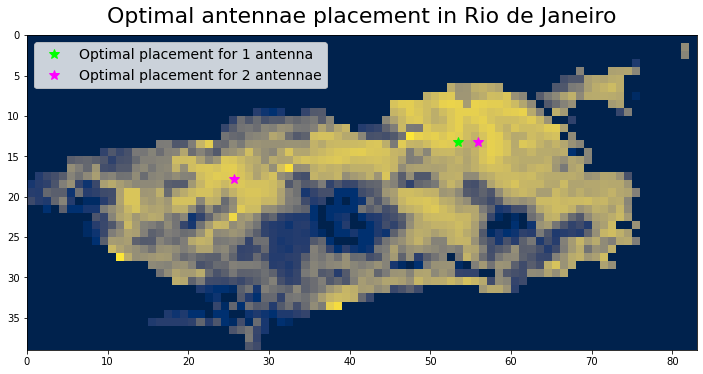

In [22]:
init_xs = [10,25,40,55,70]
init_ys = [5,15,25,35]

init_xs_meshgrid, init_ys_meshgrid = np.meshgrid(init_xs, init_ys)
init_xs_meshgrid = init_xs_meshgrid.ravel() + 0.001
init_ys_meshgrid = init_ys_meshgrid.ravel() + 0.001

final_f_obj = []
final_locs = []

for loc_init_1 in zip(init_xs_meshgrid, init_ys_meshgrid):
    for loc_init_2 in zip(init_xs_meshgrid, init_ys_meshgrid):
        loc_curr = np.hstack([loc_init_1, loc_init_2])
        locs = loc_curr

        f_obj_loc_curr = f_obj(loc_curr)
        grad_f_loc_curr = grad_f(loc_curr)
        λ = 1

        for i in range(1_000):
            loc_next = loc_curr + λ*grad_f_loc_curr
            if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim]*2) - loc_next]) <= 0):
                f_obj_loc_next = -np.inf
            else:
                f_obj_loc_next = f_obj(loc_next)

            while f_obj_loc_next < f_obj_loc_curr:
                λ = λ/2
                loc_next = loc_curr + λ*grad_f_loc_curr
                if np.any(np.hstack([loc_next, np.array([landscan_rio_xdim, landscan_rio_ydim]*2) - loc_next]) <= 0):
                    f_obj_loc_next = -np.inf
                else:
                    f_obj_loc_next = f_obj(loc_next)       

            if np.linalg.norm(loc_curr - loc_next) < 1e-5:
                break

            loc_curr = loc_next
            f_obj_loc_curr = f_obj_loc_next
            grad_f_loc_curr = grad_f(loc_curr)
            λ = λ*2

            locs = np.vstack([locs, loc_curr])

        final_f_obj += [f_obj_loc_curr]
        final_locs += [loc_curr]

loc_opt = final_locs[np.argmax(final_f_obj)]
print("loc_opt =", loc_opt)

plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_plot, cmap = 'cividis', extent = ext)
plt.plot(loc_opt_exp[0], loc_opt_exp[1], '*', color = 'lime', markersize = 10, label = "Optimal placement for 1 antenna")
plt.plot(loc_opt[0], loc_opt[1], '*', color = 'fuchsia', markersize = 10, label = "Optimal placement for 2 antennae")
plt.plot(loc_opt[2], loc_opt[3], '*', color = 'fuchsia', markersize = 10)
plt.title("Optimal antennae placement in Rio de Janeiro", fontsize = 22, y = 1.02)
plt.legend(loc = 'upper left', fontsize = 14)
plt.xlim(0, landscan_rio_xdim)
plt.ylim(landscan_rio_ydim, 0);